# This file is to formulate the GMM-HMM inside our research

From the dataset review, it is found that the release time of FFR is March 30th, but the release time of GDP growth rate for that quarter is March 31st or April 1st, which means that we as the public cannot get access to the macroeconomic factors for that period of time before the FFR is already released, hence it is imposible to forecast it based on the latest data.

As we want the macroeconomic factors as latest as possible, we try to obtain the estimation of them as close as possible, which is achieved by implementing the Hidden Markov Model to them. As treasury bond yields have close relationship with FFR, and they can be treated as the representation of the current macroeconomic condition, we choose to use them to enhance our projection.

By starting from the time of the date that the macroeconomic data are all released, for example April 1st, we aim to get the latest macroeconomic data in order to predict the FFR for the next period, which is June 29th. Hence, we can assume the model as follows:<br>

- The observable states $O_t$, t starts from 0, these are the factors generated from the treasury bond yields.
- The unobservable states $X_t$, t starts from 0, these are the representation of the Macro economic condition.

And we assume the observable states follow Gaussian Mixture Model that the mean and variance are determined by the current unobservable states. Hence, according to all the assumptions from GMM-HMM, we have the following formulas:

Transition Probability: $$p(X_t|X_{t-1})$$

GMM-HMM Observe Probability: $$p(O_t|X_t) = \sum_{i=1}^N \pi_i \cdot \mathcal{N}(\mathbf{o}|\mathbf{\mu}_i, \mathbf{\Sigma}_i)$$<br>
where $\mathbf{o}$ stands for the vectors of the observed states, $\pi_i$ stands for the $i^{th}$ weights of the mixture components, $\mu_i$ is the mean vector, $\mathbf{\Sigma}_i$ is the covariance matrix, $\mathcal{N}(\mathbf{o}|\mathbf{\mu}_i, \mathbf{\Sigma}_i)$ is the Multivariate Gaussian Distribution.

The initial state of X: $$p(X_1)$$

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as ticker
import seaborn as sns

from hmmlearn import hmm

In [10]:
yield_factors = pd.read_csv('../Github/Data/Processed/yield_usage.csv', header=[0], index_col=[0], parse_dates=True)
macro_df = pd.read_csv('../Github/Data/calculated_macro.csv', header=[0], index_col=[0], parse_dates=True)
ffr_df = pd.read_csv('../Github/Data/Raw Data/US FFR.csv', header=[0], index_col=[0], parse_dates=True).sort_index()

macro_df = macro_df.drop('Traditional Taylor Rule', axis = 1)

start_date = pd.to_datetime('1989-01-01')
macro_df = macro_df[start_date: ]
macro_df.columns = ['PCE', 'RGAP', 'FFR']
ffr_df = ffr_df[start_date: ]

For example, initially we have the PCE representing the first quarter macro information of the market, but it can only be obtained at the end of April, hence, we cannot use it to project the FFR of april the first.

Or in other words, if we want to project the FFR on 1990-07-01 (which representing the FFR based on Q2 data), we can only use the PCE and RGAP of the first quarter, that is 1990-01-01. However, we have already shifts the dataset once to create the macro_df, here we just need to shift it once again to get the started macro data.

## Example 1
Here we begin to incorporate the yield_factors for macro data projection

In [11]:
yield_data_0 = yield_factors[pd.to_datetime('1990-01-02'): pd.to_datetime('1990-03-29')]
macro_0 = macro_df.loc[pd.to_datetime('1989-10-01'), :].values.tolist()[:2]

In [17]:
# Define the parameters of GMM-HMM
n_components_per_state = 3
n_hidden_states = 1

observed_states = yield_data_0.values

hidden_states_distribution = hmm.GaussianHMM(n_components=n_components_per_state, n_iter=200, covariance_type='full')

hidden_states_distribution.fit(observed_states)

hidden_states = hidden_states_distribution.predict(observed_states)

print("Predicted Hidden States:\n", hidden_states)

Predicted Hidden States:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0 0
 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Example 2
We use the KalmanFilter Method

In [13]:
from pykalman import KalmanFilter

initial_state = np.array(macro_0[0])

transition_matrix = np.array([[1]])

observations = yield_data_0[['Level']].values.reshape(61, 1)

observation_covariance = np.eye(1) * 0.3

observation_matrix = np.eye(1)

transition_covariance = np.array([[0.01]])

initial_state_covariance = np.eye(1) * 0.3

kf = KalmanFilter(
    initial_state_mean=initial_state,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    observation_matrices=observation_matrix,
    transition_matrices=transition_matrix
)

(filtered_state_means, _) = kf.filter(observations)


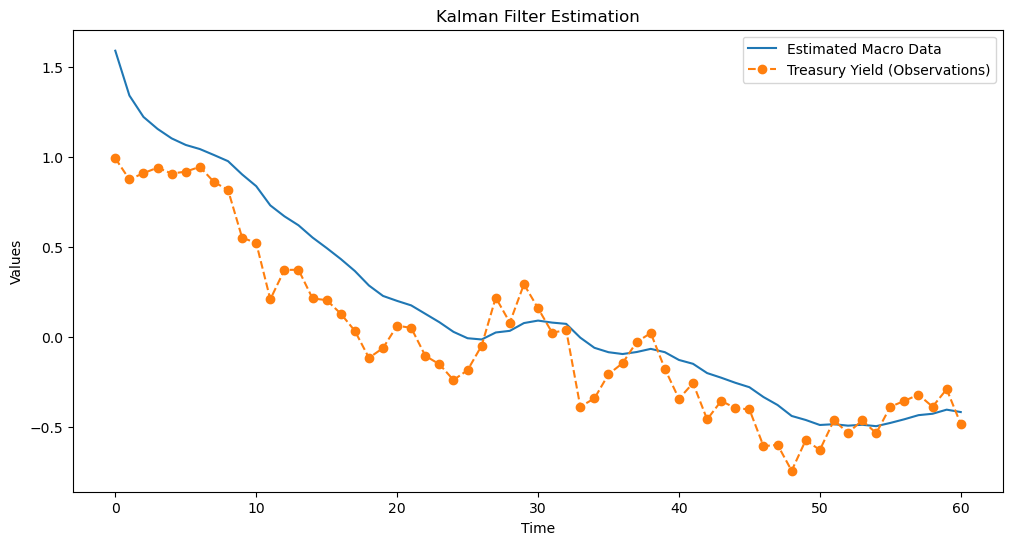

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_state_means[:, 0], label='Estimated Macro Data')
plt.plot(observations, label='Treasury Yield (Observations)', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Kalman Filter Estimation')
plt.show()

In [15]:
from pykalman import KalmanFilter

initial_state = np.array(macro_0[1])

transition_matrix = np.array([[1]])

observations = yield_data_0[['Level']].values.reshape(61, 1)

observation_covariance = np.eye(1) * 0.3

observation_matrix = np.eye(1)

transition_covariance = np.array([[0.01]])

initial_state_covariance = np.eye(1) * 0.3

kf = KalmanFilter(
    initial_state_mean=initial_state,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance,
    observation_matrices=observation_matrix,
    transition_matrices=transition_matrix
)

(filtered_state_means, _) = kf.filter(observations)

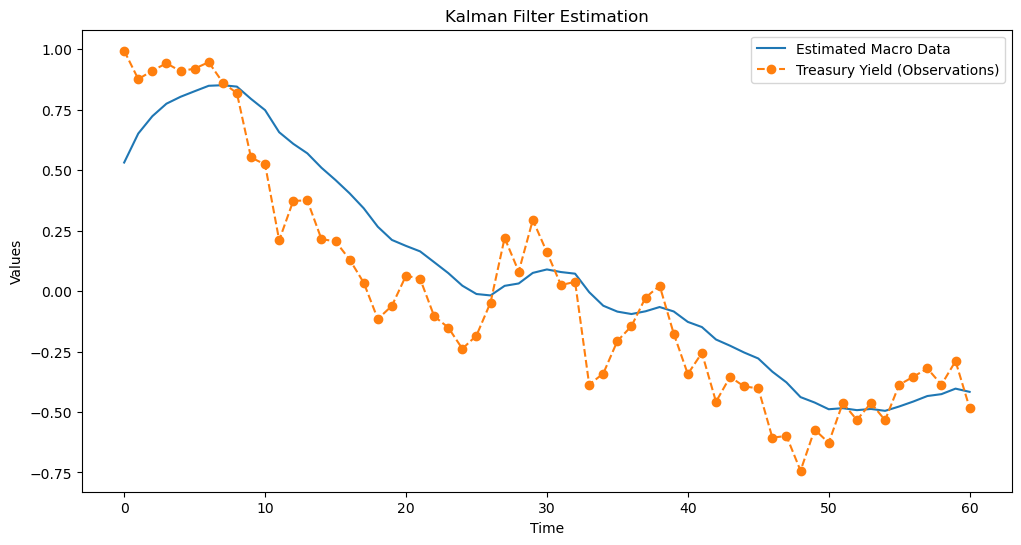

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_state_means[:, 0], label='Estimated Macro Data')
plt.plot(observations, label='Treasury Yield (Observations)', linestyle='dashed', marker='o')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Kalman Filter Estimation')
plt.show()